# start

> ## version 7 model params:
> > - taking only labled data for training:
> > - try training with Adam,AdamW [12 epochs]
> > - params: resnet50,90/10,e12,bs8,SGD,conf:0.25
> > - img_size = 480p[852x480] previously it was 720p[1280x720]

|version|training| LB |
|-------|--------|----|
|v7|FasterRCNN:resnet50,90/10,e12,bs8,SGD,cnf0.15,i480,w/o aug| 0.291 LB |
|v1|FasterRCNN:resnet50,90/10,e12,bs8,SGD,cnf0.15,i480,geo aug| ? |
| [v3](https://www.kaggle.com/soumya9977/fasterrcnn-train-color-geo-aug-480p-sgd-90-10-e20) | FasterRCNN:resnet50,90/10,e12,bs8,SGD,cnf: [0.05 - 0.5],i480,geo + color aug,e20,StepLR | ? |


### Geo Aug tried: 
- A.Flip(0.04),
- A.HorizontalFlip(0.5)
<!-- - A.VerticalFlip(0.3), -->
- A.Cutout(num_holes=25, max_h_size=6, max_w_size=6, fill_value=0, p=0.5),
- A.Resize(height=height, width=width, p=1.0), 
- A.HueSaturationValue 
- A.RandomBrightnessContrast 
- A.RGBShift 
- A.RandomGamma 
- A.Blur(p = 0.6), 
- A.GaussNoise(var_limit = (0.01, 0.05), mean = 0, p = 0.05), 
- A.ToGray(p = 0.05), 
- A.Solarize(p=0.3) , 
- A.RandomFog(fog_coef_lower = 0.1, fog_coef_upper = 0.2, p = 0.03),

-  https://debuggercafe.com/effective-model-saving-and-resuming-training-in-pytorch/

# references
- https://www.kaggle.com/c/global-wheat-detection/code?competitionId=19989&searchQuery=faster+RCNN
- https://www.kaggle.com/nvnnghia/awesome-augmentation/notebook
- https://www.kaggle.com/dhiiyaur/fasterrcnn-eda-augmentation-compare-models
- https://www.kaggle.com/aryaprince/getting-started-with-object-detection-with-pytorch
- https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
- https://www.kaggle.com/arunmohan003/fasterrcnn-using-pytorch-baseline
- https://www.kaggle.com/arunmohan003/fasterrcnn-using-pytorch-baseline
- https://www.kaggle.com/yashchoudhary/gwd-fasterrcnn-with-augmentation-train-inference
- https://www.kaggle.com/ChristianDenich/end2end-object-detection-with-fasterrcnn#Augmentations
- https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
- https://www.google.com/search?q=why+some+rotational+augmeantations+from+albumentations+gives+empty+bounding+boxes+for+fasterRCNN+training+torchvision&oq=why+some+rotational+augmeantations+from+albumentations+gives+empty+bounding+boxes+for+fasterRCNN+training+torchvision&aqs=chrome..69i57.83035j0j1&sourceid=chrome&ie=UTF-8
- https://blog.paperspace.com/data-augmentation-for-object-detection-building-input-pipelines/
- https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook

In [1]:
# %cd test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch import ToTensorV2
from torchvision import utils
import albumentations as A
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
from IPython.display import display
from torchvision import transforms
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = DEVICE
BASE_DIR = "../input/tensorflow-great-barrier-reef/train_images/"

num_epochs = 12
width = 852
height = 480

In [2]:
df = pd.read_csv("../input/reef-cv-strategy-subsequences-dataframes/train-validation-split/train-0.1.csv")

# Turn annotations from strings into lists of dictionaries
df['annotations'] = df['annotations'].apply(eval)

# Create the image path for the row
df['image_path'] = "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"

df_train, df_val = df[df['is_train']], df[~df['is_train']]

df_train = df_train[df_train.annotations.str.len() > 0 ].reset_index(drop=True)
df_val = df_val[df_val.annotations.str.len() > 0 ].reset_index(drop=True)

df_train.shape[0], df_val.shape[0]

(4396, 523)

In [3]:
"""For normal splitting"""

# train_df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
# # train_df['annotations'].iloc[3]
# train_df['annotations'] = train_df['annotations'].apply(eval)
# func = lambda x: "video_"+x.split("-")[0]+"/"+x.split("-")[1]+".jpg"
# # vid_func = lambda x: "video_"+x.split("-")[0]

# train_df["img_path"] = train_df["image_id"].apply(func)
# # train_df["vid_path"] = train_df["image_id"].apply(vid_func)
# # train_df.head()
# train_df["no_of_bbox"] = train_df["annotations"].apply(lambda x: len(x))
# train_df = train_df[train_df["no_of_bbox"]>0].reset_index(drop=True)
# train_df.head()


# train_df[train_df["no_of_bbox"]==1]


# boxes = pd.DataFrame(train_df['annotations'].iloc[19], columns=['x', 'y', 'width', 'height']).astype(float).values
# boxes

# boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
# boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
# # boxes
# # --> array([[520., 151., 598., 213.],
# #        [598., 204., 656., 236.]])

'For normal splitting'

# dataloader

In [4]:
class ReefDataset:
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def can_augment(self, boxes):
        """ Check if bounding boxes are OK to augment
        
        
        For example: image_id 1-490 has a bounding box that is partially outside of the image
        It breaks albumentation
        Here we check the margins are within the image to make sure the augmentation can be applied
        """
        
        box_outside_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not box_outside_image
        
    def get_boxes(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_min, y_min, x_max, y_max]"""
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(float).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        boxes[:, 2] = np.clip(boxes[:, 0] + boxes[:, 2],0,1280)
        boxes[:, 3] = np.clip(boxes[:, 1] + boxes[:, 3],0,720)
        return boxes
    
    def get_image(self, row):
        """Gets the image for a given row"""
        
        image = cv2.imread(f'{BASE_DIR}/{row["image_path"]}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
    def __getitem__(self, i):

        row = self.df.iloc[i]
        image = self.get_image(row)
        boxes = self.get_boxes(row)
        
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            
            'image_id': torch.tensor([i]),
            
            # There is only one class
            'labels': torch.ones((n_boxes,), dtype=torch.int64), #unchanged
            
            # Suppose all instances are not crowd
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64) #unchanged   
        }
        
#         if self.transforms is not None:
#             image, target = self.transforms(image, target)
#         return image, target

        if self.transforms and self.can_augment(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
#             target['boxes'] = torch.as_tensor(sample['bboxes'])
#             if len(tensor.size()) != 0:
#                 target['boxes'] = target['boxes'].int()
#                 target['boxes'] = target['boxes'].to(torch.float32)
#                 print(f"{torch.tensor([i])} : {target['boxes'].shape}")
#                 print(f"{torch.tensor([i])} : {target['boxes']}")
#                 print("#"*80)
#                 return image, target
#             else:
#                 continue
                
#             print(*sample['bboxes'][0])
            if n_boxes > 0:
#                 print(torch.tensor(sample['bboxes']))
                target['boxes'] = torch.as_tensor(sample['bboxes']).int()
                target['boxes'] = target['boxes'].to(torch.float32)
#                 print(f"{torch.tensor([i])} : {target['boxes'].shape}")
#                 print(f"{torch.tensor([i])} : {target['boxes']}")
#                 print("#"*80)

        else:
            image = ToTensorV2(p=1.0)(image=image)['image']
            
#         if target['boxes'].shape != (0):
        return image, target

    def __len__(self):
        return len(self.df)

# albumentations:

In [5]:

# #         A.Equalize (mode='pil', by_channels=True, mask=None, mask_params=(), always_apply=False, p=0.5),
# #         A.OneOf([
# #                 A.HueSaturationValue(hue_shift_limit = 0.2, 
# #                                      sat_shift_limit = 0.2,
# #                                      val_shift_limit = 0.2,
# #                                      p = 0.3), 
            
# #                 A.RandomBrightnessContrast(brightness_limit = 0.2,                                             
# #                                            contrast_limit = 0.2,
# # #                                            p = 0.3),
# #                 # RGB shift normally expects not-normalized images, so make sure to normalize the RGB shift!
# #                 A.RGBShift(r_shift_limit = 20/255, 
# #                            g_shift_limit = 20/255, 
# #                            b_shift_limit = 10/255,
# #                            p = 0.3)
# #             ], 
# #             p = 0.2),
# #         A.OneOf([
# #                     A.RandomGamma(gamma_limit = (80, 120),p = 0.3),
# #                     A.Blur(p = 0.6),
# #                     A.GaussNoise(var_limit = (0.01, 0.05), mean = 0, p = 0.05),
# #                     A.ToGray(p = 0.05),
# #                     A.Solarize(p=0.3)
                    
# #                 ],
# #                 p = 0.1),
# # #         A.OneOf([
# # #                     A.HorizontalFlip(p = 0.3), 
# # #                     A.VerticalFlip(p = 0.03),  
# # #                     A.Transpose(p = 0.03)                
# # # #                     A.RandomRotate90(p = 0.03)
# # #                 ], 
# # #                 p = 0.7),

# #         A.ToGray(p=0.01),
# #         A.RandomFog(fog_coef_lower = 0.1,
# #                         fog_coef_upper = 0.2,
# #                         p = 0.03),      
# #         ToTensorV2(p=1.0)
# #     ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

    
    
    
    
    
    
    
# def get_train_transforms():                  
#     return A.Compose(
#         A.Resize(height=height, width=width, p=1.0),
#         [   
            
#             A.OneOf([
#                 A.HueSaturationValue(hue_shift_limit = 0.2, 
#                                      sat_shift_limit = 0.2,
#                                      val_shift_limit = 0.2,
#                                      p = 0.3), 

#                 A.RandomBrightnessContrast(brightness_limit = 0.2,                                             
#                                            contrast_limit = 0.2,
#                                            p = 0.3),
#                 # RGB shift normally expects not-normalized images, so make sure to normalize the RGB shift!
#                 A.RGBShift(r_shift_limit = 20/255, 
#                            g_shift_limit = 20/255, 
#                            b_shift_limit = 10/255,
#                            p = 0.3)
#             ], p = 0.2),

#             A.OneOf([
#                     A.RandomGamma(gamma_limit = (80, 120),p = 0.3),
#                     A.Blur(p = 0.6),
#                     A.GaussNoise(var_limit = (0.01, 0.05), mean = 0, p = 0.05),
#                     A.ToGray(p = 0.05),
#                     A.Solarize(p=0.3)
#                 ],p = 0.1),

#     #             A.OneOf([
#     #                 A.HorizontalFlip(p = 1), 
#     #                 A.VerticalFlip(p = 1),  
#     # #                 A.Transpose(p = 1),                
#     # #                 A.RandomRotate90(p = 1)
#     #                 ], 
#     #                 p = 0.7),  
#             A.Flip(0.4),
#             A.HorizontalFlip(0.6),
#             A.VerticalFlip(0.3), 
#             A.RandomFog(fog_coef_lower = 0.1,
#                         fog_coef_upper = 0.2,
#                         p = 0.02),   

#             A.Cutout(num_holes=25, max_h_size=6, max_w_size=6, fill_value=0, p=0.5),
#             ToTensorV2(p = 1.0),
#         ],
#         p = 1.0, bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']})









# # def get_train_transform():
# #     return transforms.Compose([
# #          transforms.CenterCrop(10),
# #          transforms.PILToTensor(),
# #          transforms.ConvertImageDtype(torch.float),
# #      ])

# # import torchvision.transforms as T

# # def get_transform(train):
# #     transforms = []
# #     transforms.append(T.ToTensor())
# #     if train:
# #         transforms.append([T.RandomHorizontalFlip(0.5),
# #                          T.CenterCrop(10)]
# #                          )
# #     return T.Compose(transforms)



# # def get_train_transform():
# # #     https://tugot17.github.io/data-science-blog/albumentations/data-augmentation/tutorial/2020/09/17/Spatial-level-transforms-using-albumentations-package.html#OpticalDistortion
# #     # IAAAffine properties [creates problem]
# # #     scale=0.1
# # #     translate_percent=10
# # #     translate_px=None
# # #     rotate=0
# # #     shear=0.5
# # #     order=1
# # #     cval=0
# # #     mode='reflect'
    
# #     # rotate properties [Failed]
# # #     limit=15
# # #     interpolation=1
# # #     border_mode=4
# # #     value=None
# # #     mask_value=None
# #     # OpticalDistortion [failed]
# # #     distort_limit=1.5
# # #     shift_limit=0.4
# # #     interpolation=1
# # #     border_mode=4
# # #     value=None
# # #     mask_value=None
    
# #     return A.Compose([
# #         A.Resize(height=height, width=width, p=1.0),
# #         A.Flip(0.4),
# #         A.HorizontalFlip(0.6), # Same with transforms.RandomHorizontalFlip()
# # #         A.SafeRotate(limit = 15, p = 0.5), 
# #         A.VerticalFlip(0.3), 
# # #         A.RandomRotate90(p = 0.5),
# # #         A.OneOf([
# # #             A.RGBShift(), 
# # #             A.HueSaturationValue()
# # #         ]),
# # #         A.OpticalDistortion(distort_limit, shift_limit, interpolation, border_mode, value, mask_value, p=0.5),

# # #         A.HueSaturationValue(),
# # #         A.IAAAffine(scale, translate_percent, translate_px, rotate, shear, order, cval, mode, p=0.4),
# # #         A.Rotate(limit, interpolation, border_mode, value, mask_value, p=0.5),
# #         A.Cutout(num_holes=25, max_h_size=6, max_w_size=6, fill_value=0, p=0.5),
# # #         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
# #         ToTensorV2(p=1.0)
# #     ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# # Mean of the image: [0.222, 0.577, 0.658]
# # Std of the image: [0.175, 0.176, 0.162]
# # def get_train_transform():
# #     return A.Compose([
# #         A.RandomSizedCrop(min_max_height=(500, 500), height=1024, width=1024, p=0.5),
# #         A.OneOf([
# #             A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
# #                                  val_shift_limit=0.2, p=0.9),
# #             A.RandomBrightnessContrast(brightness_limit=0.2, 
# #                                        contrast_limit=0.2, p=0.9),
# #         ],p=0.9),
# #         A.ToGray(p=0.01),
# #         A.HorizontalFlip(p=0.5),
# #         A.VerticalFlip(p=0.5),
# #         A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
# #         ToTensorV2(p=1.0)
# #     ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# def get_valid_transform():
#     return A.Compose([
#         ToTensorV2(p=1.0)
#     ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [6]:
def get_train_transforms():  
    
    return A.Compose([  
            A.Resize(height=height, width=width, p=1.0),
            A.OneOf([
                    A.HueSaturationValue(hue_shift_limit = 0.2, 
                                         sat_shift_limit = 0.2,
                                         val_shift_limit = 0.2,
                                         p = 0.3), 
                    A.RandomBrightnessContrast(brightness_limit = 0.2,                                             
                                               contrast_limit = 0.2,
                                               p = 0.3),
                    A.RGBShift(r_shift_limit = 20/255, 
                               g_shift_limit = 20/255, 
                               b_shift_limit = 10/255,
                               p = 0.3)
            ], p = 0.2),
            A.OneOf([
                    A.RandomGamma(gamma_limit = (80, 120),p = 0.3),
                    A.Blur(p = 0.6),
                    A.GaussNoise(var_limit = (0.01, 0.05), mean = 0, p = 0.05),
                    A.ToGray(p = 0.05),
                    A.Solarize(p=0.3)
                ],p = 0.1),  
            A.Flip(0.05),
            A.HorizontalFlip(0.5),
#             A.VerticalFlip(0.3), 
            A.RandomFog(fog_coef_lower = 0.1,
                        fog_coef_upper = 0.2,
                        p = 0.02),   
            A.Cutout(num_holes=25, max_h_size=6, max_w_size=6, fill_value=0, p=0.5),
            ToTensorV2(p = 1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# def get_train_transform():
#     return A.Compose([
#         A.Resize(height=height, width=width, p=1.0),
#         A.Flip(0.4),
#         A.HorizontalFlip(0.6),
#         A.VerticalFlip(0.3), 
#         A.Cutout(num_holes=25, max_h_size=6, max_w_size=6, fill_value=0, p=0.5),
#         ToTensorV2(p=1.0)
#     ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



def get_valid_transforms():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [7]:
# df_train = train_df.iloc[0: 1427]
# df_val = train_df.iloc[1428:1918]

ds_train = ReefDataset(df_train,get_train_transforms())
ds_val = ReefDataset(df_val,get_valid_transforms())

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [8]:
image, targets = ds_train[45]
# image = image.permute(2,1,0).numpy()
# plt.imshow(image)
# img = image.permute(1,2,0).cpu().numpy()
# # plt.imshow(image.numpy().reshape((720, 1280,3)))
# print(img.shape)
# plt.figure(figsize=(16,18))


# plt.imshow(img)

"""
boxes:  [[344. 105.  66.  73.]]
[66.]
"""

'\nboxes:  [[344. 105.  66.  73.]]\n[66.]\n'

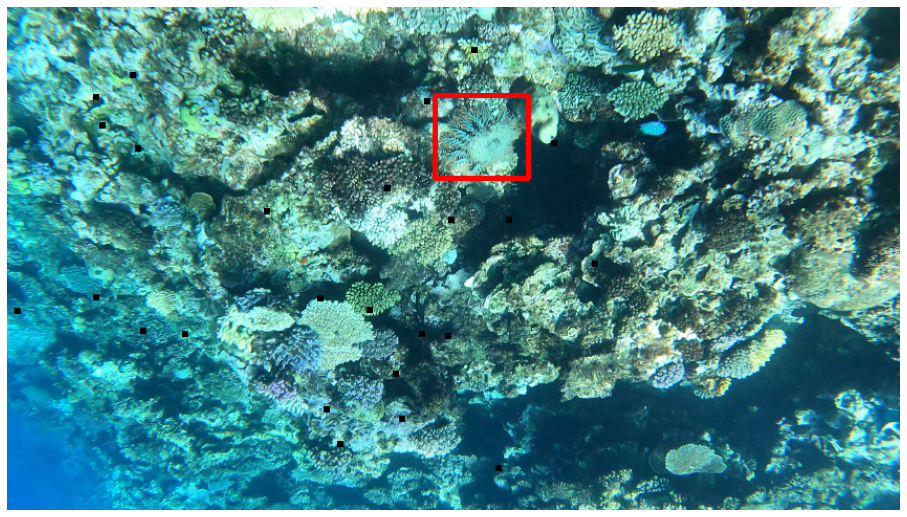

In [9]:
boxes = targets['boxes'].cpu().numpy().astype(np.int32)

img2 = image.permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 18))

for box in boxes:
    cv2.rectangle(img2,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
# fig.figure(figsize=(16,18))
ax.imshow(img2);

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

dl_train = DataLoader(ds_train, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)
dl_val = DataLoader(ds_val, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
# for img,trg in dl_train:
#     print(trg[0].shape)
#     break

# model:

In [12]:
def get_model():
    # load a model; pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    num_classes = 2  # 1 class (starfish) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.to(device)
    return model

model = get_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

# F2 cal:

In [13]:
from typing import List

import numpy as np
import torch
from torchvision.ops import box_iou


def calculate_score(
    preds: List[torch.Tensor],
    gts: List[torch.Tensor],
    iou_th: float
) -> float:
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, gt in zip(preds, gts):
        if len(p) and len(gt):
            iou_matrix = box_iou(p, gt)
            tp = len(torch.where(iou_matrix.max(0)[0] >= iou_th)[0])
            fp = len(p) - tp
            fn = len(torch.where(iou_matrix.max(0)[0] < iou_th)[0])
            num_tp += tp
            num_fp += fp
            num_fn += fn
        elif len(p) == 0 and len(gt):
            num_fn += len(gt)
        elif len(p) and len(gt) == 0:
            num_fp += len(p)
    if (5 * num_tp + 4 * num_fn + num_fp )!=0:
        score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp )
    else:
        score = np.nan
    if (num_tp+num_fn) != 0:
        recall = num_tp/ (num_tp+num_fn)
    else:
        recall=np.nan
    if (num_tp+num_fp)!=0:
        precission = num_tp/ (num_tp+num_fp)
    else:
        precission=np.nan


    return score, precission, recall




# Training:

In [14]:


# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
# # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None
# confthre = 0.25
# n_batches, n_batches_val = len(dl_train), len(dl_val)
# validation_losses = []
# train_need = True

# for epoch in range(NUM_EPOCHS):
#     time_start = time.time()
#     loss_accum = 0
    
#     for batch_idx, (images, targets) in enumerate(dl_train, 1):
#         model = model.train()
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         # Predict
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()

#         loss_accum += loss_value

#         # Back-prop
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

    
#     # update the learning rate
#     if lr_scheduler is not None:
#         lr_scheduler.step()
        
#     # Validation 
#     val_loss_accum = 0
    
    
#     iou_ths = np.arange(0.3, 0.85, 0.05)
    
#     with torch.no_grad():
#         for batch_idx, (images, targets) in enumerate(dl_val, 1):
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
#             val_loss_dict = model(images, targets)
# #             print(val_loss_dict)
#             val_batch_loss = sum(loss for loss in val_loss_dict.values())
#             val_loss_accum += val_batch_loss.item()
            
            
#     val_f2_scores = []
    
#     for batch_idx, (images, targets) in enumerate(dl_val):


#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]     
#         model = model.eval()
#         preds = model(images)
            
#         for i in range(len(images)):
            
# #             print(preds[i]['boxes'].dtype)
# #             print(preds[i]['scores'].dtype)
# #             print(preds[i]['labels'].dtype)

#             preds[i]['boxes']=preds[i]['boxes'][preds[i]['scores']>confthre]
#             preds[i]['boxes']=preds[i]['boxes'].int()
#             score = [calculate_score(preds[i]['boxes'].unsqueeze(0), targets[i]['boxes'].unsqueeze(0), iou_th)[0] for iou_th in iou_ths]
#             val_f2_scores.append(np.nanmean(score))
    
    
#     # Logging
#     val_loss = val_loss_accum / n_batches_val
#     train_loss = loss_accum / n_batches
#     validation_losses.append(val_loss)
    
#     # Save model
#     chk_name = f'fasterrcnn_resnet50_fpn-e{epoch}.pth'
#     torch.save(model.state_dict(), chk_name)
    
    
#     elapsed = time.time() - time_start
    
#     print(f"[Epoch {epoch+1:2d} / {NUM_EPOCHS:2d}] Train loss: {train_loss:.3f}. Val loss: {val_loss:.3f} --> {chk_name} val F2: {np.nanmean(val_f2_scores):.3f} | time: [{elapsed:.0f} secs] ")   

# training 1:

In [15]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [16]:
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
# # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None
# itr = 1
# confthre = 0.15
# n_batches, n_batches_val = len(dl_train), len(dl_val)
# validation_losses = []
# NUM_EPOCHS = 2

# for epoch in range(NUM_EPOCHS):
#     time_start = time.time()
#     loss_accum = 0
    
#     for batch_idx, (images, targets) in enumerate(dl_train, 1):
        
# #         images = list(image.to(DEVICE) for image in images)
# #         targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
#         images = list(image.float().to(DEVICE) for image in images)
#         targets = [{k: v.to(torch.float32).to(DEVICE) if "box" in k else v.to(DEVICE) for k, v in t.items()} for t in targets]

#         # Predict
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()

#         loss_accum += loss_value

#         # Back-prop
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

        
#         if itr % 50 == 0:
#             print(f"Iteration #{itr} loss: {loss_value}")

#         itr += 1
    
#     # update the learning rate
#     if lr_scheduler is not None:
#         lr_scheduler.step()

# #     # Validation 
# #     val_loss_accum = 0
        
# #     with torch.no_grad():
# #         for batch_idx, (images, targets) in enumerate(dl_val, 1):
# #             images = list(image.to(DEVICE) for image in images)
# #             targets = [{k: v.to(torch.float32).to(DEVICE) if "box" in k else v.to(DEVICE) for k, v in t.items()} for t in targets]

            
# #             val_loss_dict = model(images, targets)
# #             val_batch_loss = sum(loss for loss in val_loss_dict.values())
# #             val_loss_accum += val_batch_loss.item()
    
    
    
#     val_f2_scores = []
#     iou_ths = np.arange(0.3, 0.85, 0.05)
#     for batch_idx, (images, targets) in enumerate(dl_val):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]     
#         model1 = model.eval()
#         preds = model1(images)
#         for i in range(len(images)):
#             preds[i]['boxes']=preds[i]['boxes'][preds[i]['scores']>confthre]
#             preds[i]['boxes']=preds[i]['boxes'].int()
#             score = [calculate_score(preds[i]['boxes'].unsqueeze(0), targets[i]['boxes'].unsqueeze(0), iou_th)[0] for iou_th in iou_ths]
#             val_f2_scores.append(np.nanmean(score))
    
    
#     # Logging
# #     val_loss = val_loss_accum / n_batches_val
#     train_loss = loss_accum / n_batches
# #     validation_losses.append(val_loss)
    
#     # Save model
#     chk_name = f'fasterrcnn_resnet50_fpn-e{epoch}.bin'
#     torch.save(model.state_dict(), chk_name)
    
    
#     elapsed = time.time() - time_start
#     # Val loss: {val_loss:.3f}
#     print(f"[Epoch {epoch+1:2d} / {NUM_EPOCHS:2d}] Train loss: {train_loss:.3f}. |  val F2: {np.nanmean(val_f2_scores):.3f} --> {chk_name}  [{elapsed:.0f} secs]") 

In [17]:
# loss_hist = Averager()
# itr = 1
# num_epochs = 12
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# # lr_scheduler = None
# confthre = 0.15
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# n_batches, n_batches_val = len(dl_train), len(dl_val)


# for epoch in range(num_epochs):
#     print("#"*20 + f"   New epoch [{epoch+1}/{num_epochs}]  " + "#"*20) 
#     print()
#     loss_hist.reset()
#     loss_accum = 0
#     train_time_start = time.time()
    
    
#     for batch_idx, (images, targets) in enumerate(dl_train, 1):
#         model = model.train()
# #         images = list(image.to(device) for image in images)
# #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         images = list(image.float().to(DEVICE) for image in images)
#         targets = [{k: v.to(torch.float32).to(DEVICE) if "box" in k else v.to(DEVICE) for k, v in t.items()} for t in targets]
# #         print(i["boxes"].shape for i in targets )
#         # Predict
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()

#         loss_accum += loss_value

#         # Back-prop
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()
# #     for images, targets, image_ids in train_data_loader:
        
# #         images = list(image.to(device) for image in images)
# #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# #         loss_dict = model(images, targets)

# #         losses = sum(loss for loss in loss_dict.values())
# #         loss_value = losses.item()

# #         loss_hist.send(loss_value)

# #         optimizer.zero_grad()
# #         losses.backward()
# #         optimizer.step()

#         if itr % 50 == 0:
#             print(f"Iteration #{itr} loss: {loss_value:.4f}")

#         itr += 1
    
#     # update the learning rate
#     if lr_scheduler is not None:
#         lr_scheduler.step()
    
    
    
#     val_f2_scores = []
#     iou_ths = np.arange(0.3, 0.85, 0.05)

#     for batch_idx, (images, targets) in enumerate(dl_val):


#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]     
#         model1 = model.eval()
#         preds = model1(images)
            
#         for i in range(len(images)):
            
#             preds[i]['boxes']=preds[i]['boxes'][preds[i]['scores']>confthre]
#             preds[i]['boxes']=preds[i]['boxes'].int()
#             score = [calculate_score(preds[i]['boxes'].unsqueeze(0), targets[i]['boxes'].unsqueeze(0), iou_th)[0] for iou_th in iou_ths]
#             val_f2_scores.append(np.nanmean(score))
    
#     train_loss = loss_accum / n_batches
    
    
#     PATH = f'fasterrcnn_resnet50_fpn-e{epoch}.pt'
#     torch.save(model.state_dict(), PATH)
    
#     elapsed = time.time() - train_time_start
    
    
       
#     print(f"Epoch [{epoch+1}/{num_epochs}] train loss: {train_loss:.3f}  |  saving file to: {PATH}  |  val F2: {np.nanmean(val_f2_scores):.3f} | time: [{elapsed:.0f} secs]") 
# #     print("~"*80)
#     print()

# train val loop def

In [18]:
# function for running training iterations
def train(train_data_loader, model, lr_scheduler):
    model = model.train()
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
#         if train_itr % 50 == 0:
#             print(f"Iteration #{train_itr} loss: {loss_value:.4f}")

        train_itr += 1
        
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
        
    return train_loss_list


# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list


In [19]:
def save_model(epoch, model, optimizer, model_path):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_path)

In [20]:
# import numpy as np
# conf_list = [0.12,0.14,0.15]
# f2_conf_bucket = dict()
# for confthre in conf_list:
#     f2_conf_bucket[confthre] = 3

# conf_list = np.arange(0,0.75,0.05)
# # print(conf_list.shape) 
# header1 = ""
# for i in conf_list[0:8]:
#     header1 += "F2: " + str(round(i,2)) + '\t' +"  "
    
# header2 = ""
# for i in conf_list[8:15]:
#     header2 += "F2: " + str(round(i,2)) + '\t' +"  "
    
    
# print(header2)
# # print(header)
# # print()
# # # print(f2_conf_bucket)
# # print("Thresh\tTP\tFP\tFN\tPrec.")

# # print("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:1.3f}".format(0.1222,112.3132,134.142411,132.12312,2342.123))

# calc_f2

In [21]:
def calc_f2(dl_val,model):
    conf_list = np.arange(0.05,0.55,0.05)
    f2_conf_bucket = []
    start_time = time.time()
    prog_bar = tqdm(conf_list)
    for confthre in prog_bar:
        val_f2_scores = []
        iou_ths = np.arange(0.3, 0.85, 0.05)
        for batch_idx, (images, targets) in enumerate(dl_val):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]     
            model1 = model.eval()
            preds = model1(images)

            for i in range(len(images)):
                preds[i]['boxes']=preds[i]['boxes'][preds[i]['scores']>confthre]
                preds[i]['boxes']=preds[i]['boxes'].int()
                score = [calculate_score(preds[i]['boxes'].unsqueeze(0), targets[i]['boxes'].unsqueeze(0), iou_th)[0] for iou_th in iou_ths]
                val_f2_scores.append(np.nanmean(score))
        f2_conf_bucket.append(np.nanmean(val_f2_scores))
    
    elapsed  = time.time() - start_time
    return f2_conf_bucket, elapsed

In [22]:
def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')
    plt.close('all')

In [23]:
# import numpy as np
# conf_list = [[0.12,0.14,0.15],
#              [0.12,0.14,0.15],
#              [0.12,0.14,0.15],
#              [0.12,0.14,0.15]]

# f2_cat = [str(round(i,3)) for i in np.arange(0.05,0.75,0.05)]
# print(len(f2_cat))
# dataf_dict = {}
# for i in range(3):
#     dataf_dict[f2_cat[i]] = [j[i] for j in conf_list]
    
# # print(dataf_dict)
# import pandas as pd
# f2_df = pd.DataFrame(dataf_dict)
# f2_df.head()
# f2_df.to_csv("f2log_per_epoch.csv")


# loss_dict = {"val_loss": val_loss_per_epoch,"train_loss": train_loss_per_epoch}
# loss_df = pd.DataFrame(dataf_dict)
# loss_df.to_csv("train_val_loss_log.csv")

# train loop main

In [24]:
# Reference: https://debuggercafe.com/a-simple-pipeline-to-train-pytorch-faster-rcnn-object-detection-model/

import torch
from tqdm import tqdm

conf_list = np.arange(0.05,0.55,0.05)
header1 = ""
for i in conf_list[0:8]:
    header1 += "F2: " + str(round(i,2)) + "\t" + "  "
    
header2 = ""
for i in conf_list[8:15]:
    header2 += "F2: " + str(round(i,2))+ "\t" + "  "
    
BATCH_SIZE = 8 
NUM_EPOCHS = 20
NUM_WORKERS = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

OUT_DIR = './outputs'
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
    
PLOT_DIR = './outputs/logs'
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

train_loss_per_epoch = []
val_loss_per_epoch = []
f2_per_conf = []

for epoch in range(NUM_EPOCHS):
#     print(f"\nEPOCH [{epoch+1}/{NUM_EPOCHS}]")
    print("#"*20 + f"   New epoch [{epoch+1}/{NUM_EPOCHS}]  " + "#"*20) 
    
    train_loss_hist.reset()
    val_loss_hist.reset()

    start = time.time()
    train_loss = train(dl_train, model,lr_scheduler)
    val_loss = validate(dl_val, model)
    f2_list, elapsed = calc_f2(dl_val, model)
    f2_per_conf.append(f2_list)
    train_loss_per_epoch.append(train_loss_hist.value)
    val_loss_per_epoch.append(val_loss_hist.value)

    PATH = OUT_DIR + "/" +f'fasterrcnn_resnet50_fpn-e{epoch+1}.pt'
    save_model(epoch, model, optimizer,PATH)
    save_loss_plot(PLOT_DIR, train_loss, val_loss)
    
    end = time.time()
    
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f} || validation loss: {val_loss_hist.value:.3f} || Elapsed: {((end - start) / 60):.3f} min")   
    print()
    print("="*20 + f" F2 calculation [{elapsed/60:.3f} min] " + "="*20)
    print(header1)
    print(f"{f2_list[0]:.3f}\t{f2_list[1]:.3f}\t{f2_list[2]:.3f}\t{f2_list[3]:.3f}\t{f2_list[4]:.3f}") 
    print()
    print(header2)
    print(f"{f2_list[5]:.3f}\t{f2_list[6]:.3f}\t{f2_list[7]:.3f}\t{f2_list[8]:.3f}\t{f2_list[9]:.3f}")    
    print()

####################   New epoch [1/20]  ####################
Training


Loss: 0.1444: 100%|██████████| 550/550 [11:36<00:00,  1.27s/it]


Validating


100%|██████████| 10/10 [07:38<00:00, 45.81s/it]


SAVING PLOTS COMPLETE...
Epoch #1 train loss: 0.248 || validation loss: 0.235 || Elapsed: 20.014 min

==================== F2 calculation [7.635 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.153	0.145	0.127	0.099	0.071

F2: 0.45	  F2: 0.5	  
0.054	0.035	0.024	0.013	0.005

####################   New epoch [2/20]  ####################
Training


Loss: 0.1227: 100%|██████████| 550/550 [11:31<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [07:48<00:00, 46.88s/it]


SAVING PLOTS COMPLETE...
Epoch #2 train loss: 0.242 || validation loss: 0.250 || Elapsed: 20.134 min

==================== F2 calculation [7.813 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.160	0.194	0.202	0.198	0.194

F2: 0.45	  F2: 0.5	  
0.187	0.178	0.168	0.157	0.144

####################   New epoch [3/20]  ####################
Training


Loss: 0.1521: 100%|██████████| 550/550 [11:31<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [07:55<00:00, 47.52s/it]


SAVING PLOTS COMPLETE...
Epoch #3 train loss: 0.243 || validation loss: 0.246 || Elapsed: 20.235 min

==================== F2 calculation [7.920 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.171	0.216	0.233	0.239	0.235

F2: 0.45	  F2: 0.5	  
0.233	0.231	0.226	0.225	0.221

####################   New epoch [4/20]  ####################
Training


Loss: 0.1139: 100%|██████████| 550/550 [11:31<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [07:56<00:00, 47.65s/it]


SAVING PLOTS COMPLETE...
Epoch #4 train loss: 0.244 || validation loss: 0.236 || Elapsed: 20.253 min

==================== F2 calculation [7.942 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.225	0.282	0.296	0.314	0.307

F2: 0.45	  F2: 0.5	  
0.306	0.296	0.295	0.289	0.285

####################   New epoch [5/20]  ####################
Training


Loss: 0.1467: 100%|██████████| 550/550 [11:33<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [07:57<00:00, 47.73s/it]


SAVING PLOTS COMPLETE...
Epoch #5 train loss: 0.242 || validation loss: 0.235 || Elapsed: 20.303 min

==================== F2 calculation [7.955 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.233	0.290	0.303	0.317	0.314

F2: 0.45	  F2: 0.5	  
0.312	0.304	0.303	0.296	0.290

####################   New epoch [6/20]  ####################
Training


Loss: 0.1454: 100%|██████████| 550/550 [11:34<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [08:01<00:00, 48.17s/it]


SAVING PLOTS COMPLETE...
Epoch #6 train loss: 0.241 || validation loss: 0.237 || Elapsed: 20.392 min

==================== F2 calculation [8.028 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.243	0.296	0.307	0.322	0.328

F2: 0.45	  F2: 0.5	  
0.324	0.314	0.307	0.302	0.295

####################   New epoch [7/20]  ####################
Training


Loss: 0.1416: 100%|██████████| 550/550 [11:35<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [08:03<00:00, 48.37s/it]


SAVING PLOTS COMPLETE...
Epoch #7 train loss: 0.244 || validation loss: 0.231 || Elapsed: 20.438 min

==================== F2 calculation [8.062 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.222	0.281	0.309	0.316	0.327

F2: 0.45	  F2: 0.5	  
0.332	0.334	0.329	0.324	0.316

####################   New epoch [8/20]  ####################
Training


Loss: 0.1869: 100%|██████████| 550/550 [11:33<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [08:02<00:00, 48.21s/it]


SAVING PLOTS COMPLETE...
Epoch #8 train loss: 0.241 || validation loss: 0.231 || Elapsed: 20.375 min

==================== F2 calculation [8.036 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.229	0.282	0.313	0.322	0.328

F2: 0.45	  F2: 0.5	  
0.333	0.337	0.331	0.327	0.317

####################   New epoch [9/20]  ####################
Training


Loss: 0.1672: 100%|██████████| 550/550 [11:34<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [08:01<00:00, 48.17s/it]


SAVING PLOTS COMPLETE...
Epoch #9 train loss: 0.240 || validation loss: 0.230 || Elapsed: 20.382 min

==================== F2 calculation [8.029 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.229	0.287	0.313	0.321	0.332

F2: 0.45	  F2: 0.5	  
0.333	0.336	0.332	0.325	0.320

####################   New epoch [10/20]  ####################
Training


Loss: 0.1487: 100%|██████████| 550/550 [11:35<00:00,  1.27s/it]


Validating


100%|██████████| 10/10 [08:02<00:00, 48.29s/it]


SAVING PLOTS COMPLETE...
Epoch #10 train loss: 0.241 || validation loss: 0.230 || Elapsed: 20.451 min

==================== F2 calculation [8.048 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.229	0.287	0.313	0.321	0.332

F2: 0.45	  F2: 0.5	  
0.333	0.337	0.332	0.325	0.320

####################   New epoch [11/20]  ####################
Training


Loss: 0.1518: 100%|██████████| 550/550 [11:35<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [08:03<00:00, 48.38s/it]


SAVING PLOTS COMPLETE...
Epoch #11 train loss: 0.241 || validation loss: 0.230 || Elapsed: 20.453 min

==================== F2 calculation [8.064 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.230	0.287	0.313	0.321	0.331

F2: 0.45	  F2: 0.5	  
0.333	0.337	0.333	0.325	0.320

####################   New epoch [12/20]  ####################
Training


Loss: 0.1729: 100%|██████████| 550/550 [11:35<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [08:03<00:00, 48.33s/it]


SAVING PLOTS COMPLETE...
Epoch #12 train loss: 0.241 || validation loss: 0.230 || Elapsed: 20.453 min

==================== F2 calculation [8.055 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.230	0.288	0.314	0.322	0.332

F2: 0.45	  F2: 0.5	  
0.335	0.338	0.334	0.325	0.322

####################   New epoch [13/20]  ####################
Training


Loss: 0.1825: 100%|██████████| 550/550 [11:36<00:00,  1.27s/it]


Validating


100%|██████████| 10/10 [08:03<00:00, 48.39s/it]


SAVING PLOTS COMPLETE...
Epoch #13 train loss: 0.241 || validation loss: 0.230 || Elapsed: 20.477 min

==================== F2 calculation [8.066 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.230	0.288	0.314	0.322	0.332

F2: 0.45	  F2: 0.5	  
0.335	0.338	0.334	0.324	0.322

####################   New epoch [14/20]  ####################
Training


Loss: 0.1605: 100%|██████████| 550/550 [11:35<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [08:02<00:00, 48.29s/it]


SAVING PLOTS COMPLETE...
Epoch #14 train loss: 0.242 || validation loss: 0.230 || Elapsed: 20.447 min

==================== F2 calculation [8.048 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.231	0.287	0.314	0.322	0.332

F2: 0.45	  F2: 0.5	  
0.335	0.338	0.334	0.324	0.322

####################   New epoch [15/20]  ####################
Training


Loss: 0.1694: 100%|██████████| 550/550 [11:36<00:00,  1.27s/it]


Validating


100%|██████████| 10/10 [08:06<00:00, 48.66s/it]


SAVING PLOTS COMPLETE...
Epoch #15 train loss: 0.240 || validation loss: 0.230 || Elapsed: 20.530 min

==================== F2 calculation [8.110 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.231	0.287	0.313	0.322	0.332

F2: 0.45	  F2: 0.5	  
0.335	0.338	0.334	0.324	0.322

####################   New epoch [16/20]  ####################
Training


Loss: 0.1598: 100%|██████████| 550/550 [11:36<00:00,  1.27s/it]


Validating


100%|██████████| 10/10 [08:04<00:00, 48.47s/it]


SAVING PLOTS COMPLETE...
Epoch #16 train loss: 0.241 || validation loss: 0.230 || Elapsed: 20.481 min

==================== F2 calculation [8.079 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.231	0.287	0.313	0.322	0.332

F2: 0.45	  F2: 0.5	  
0.335	0.338	0.334	0.325	0.322

####################   New epoch [17/20]  ####################
Training


Loss: 0.1630: 100%|██████████| 550/550 [11:36<00:00,  1.27s/it]


Validating


100%|██████████| 10/10 [08:02<00:00, 48.25s/it]


SAVING PLOTS COMPLETE...
Epoch #17 train loss: 0.240 || validation loss: 0.230 || Elapsed: 20.455 min

==================== F2 calculation [8.041 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.231	0.287	0.313	0.322	0.332

F2: 0.45	  F2: 0.5	  
0.335	0.338	0.334	0.325	0.322

####################   New epoch [18/20]  ####################
Training


Loss: 0.1319: 100%|██████████| 550/550 [11:35<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [08:03<00:00, 48.36s/it]


SAVING PLOTS COMPLETE...
Epoch #18 train loss: 0.241 || validation loss: 0.230 || Elapsed: 20.429 min

==================== F2 calculation [8.060 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.231	0.287	0.313	0.322	0.332

F2: 0.45	  F2: 0.5	  
0.335	0.338	0.334	0.325	0.322

####################   New epoch [19/20]  ####################
Training


Loss: 0.1582: 100%|██████████| 550/550 [11:34<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [08:02<00:00, 48.26s/it]


SAVING PLOTS COMPLETE...
Epoch #19 train loss: 0.240 || validation loss: 0.230 || Elapsed: 20.398 min

==================== F2 calculation [8.044 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.231	0.287	0.313	0.322	0.332

F2: 0.45	  F2: 0.5	  
0.335	0.338	0.334	0.325	0.322

####################   New epoch [20/20]  ####################
Training


Loss: 0.1644: 100%|██████████| 550/550 [11:34<00:00,  1.26s/it]


Validating


100%|██████████| 10/10 [08:03<00:00, 48.37s/it]


SAVING PLOTS COMPLETE...
Epoch #20 train loss: 0.241 || validation loss: 0.230 || Elapsed: 20.448 min

==================== F2 calculation [8.062 min] ====================
F2: 0.05	  F2: 0.1	  F2: 0.15	  F2: 0.2	  F2: 0.25	  F2: 0.3	  F2: 0.35	  F2: 0.4	  
0.231	0.287	0.313	0.322	0.332

F2: 0.45	  F2: 0.5	  
0.335	0.338	0.334	0.325	0.322



In [25]:
f2_cat = [str(round(i,3)) for i in np.arange(0.05,0.55,0.05)]

dataf_dict = {}
for i in range(10):
    dataf_dict[f2_cat[i]] = [j[i] for j in f2_per_conf]

f2_df = pd.DataFrame(dataf_dict)
display(f2_df.head())
f2_df.to_csv(PLOT_DIR + "/" + "f2log_per_epoch.csv")


loss_dict = {"val_loss": val_loss_per_epoch,"train_loss": train_loss_per_epoch}
loss_df = pd.DataFrame(dataf_dict)
display(loss_df.head())
loss_df.to_csv(PLOT_DIR + "/" + "train_val_loss_log.csv")

,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5
0,0.153127,0.145142,0.126939,0.098806,0.070964,0.054184,0.035207,0.023968,0.012966,0.004760
1,0.160395,0.193976,0.201586,0.197877,0.194281,0.187126,0.178310,0.167742,0.156534,0.143594
2,0.171361,0.215779,0.232647,0.238691,0.234582,0.232808,0.231243,0.226432,0.224581,0.220965
3,0.225137,0.281835,0.296314,0.313749,0.306772,0.306322,0.295578,0.295016,0.289497,0.284737
4,0.232878,0.289954,0.302628,0.317201,0.314396,0.312038,0.304201,0.303204,0.295741,0.290074


,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5
0,0.153127,0.145142,0.126939,0.098806,0.070964,0.054184,0.035207,0.023968,0.012966,0.004760
1,0.160395,0.193976,0.201586,0.197877,0.194281,0.187126,0.178310,0.167742,0.156534,0.143594
2,0.171361,0.215779,0.232647,0.238691,0.234582,0.232808,0.231243,0.226432,0.224581,0.220965
3,0.225137,0.281835,0.296314,0.313749,0.306772,0.306322,0.295578,0.295016,0.289497,0.284737
4,0.232878,0.289954,0.302628,0.317201,0.314396,0.312038,0.304201,0.303204,0.295741,0.290074


In [26]:
# # ValueError: Expected target boxes to be a tensorof shape [N, 4], got torch.Size([0]).
# for img,trg in dl_train:
#     if trg[0]["boxes"].shape == (0):
#         print("hi")
#         print(" length -----> ", trg[0]["boxes"].shape)
#     break

In [27]:
# print("#"*12 + "hi absdfobasodb")

In [28]:
loaded_model = get_model()
loaded_model.load_state_dict(torch.load( "./outputs/fasterrcnn_resnet50_fpn-e1.pt"))

RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	Missing key(s) in state_dict: "backbone.body.conv1.weight", "backbone.body.bn1.weight", "backbone.body.bn1.bias", "backbone.body.bn1.running_mean", "backbone.body.bn1.running_var", "backbone.body.layer1.0.conv1.weight", "backbone.body.layer1.0.bn1.weight", "backbone.body.layer1.0.bn1.bias", "backbone.body.layer1.0.bn1.running_mean", "backbone.body.layer1.0.bn1.running_var", "backbone.body.layer1.0.conv2.weight", "backbone.body.layer1.0.bn2.weight", "backbone.body.layer1.0.bn2.bias", "backbone.body.layer1.0.bn2.running_mean", "backbone.body.layer1.0.bn2.running_var", "backbone.body.layer1.0.conv3.weight", "backbone.body.layer1.0.bn3.weight", "backbone.body.layer1.0.bn3.bias", "backbone.body.layer1.0.bn3.running_mean", "backbone.body.layer1.0.bn3.running_var", "backbone.body.layer1.0.downsample.0.weight", "backbone.body.layer1.0.downsample.1.weight", "backbone.body.layer1.0.downsample.1.bias", "backbone.body.layer1.0.downsample.1.running_mean", "backbone.body.layer1.0.downsample.1.running_var", "backbone.body.layer1.1.conv1.weight", "backbone.body.layer1.1.bn1.weight", "backbone.body.layer1.1.bn1.bias", "backbone.body.layer1.1.bn1.running_mean", "backbone.body.layer1.1.bn1.running_var", "backbone.body.layer1.1.conv2.weight", "backbone.body.layer1.1.bn2.weight", "backbone.body.layer1.1.bn2.bias", "backbone.body.layer1.1.bn2.running_mean", "backbone.body.layer1.1.bn2.running_var", "backbone.body.layer1.1.conv3.weight", "backbone.body.layer1.1.bn3.weight", "backbone.body.layer1.1.bn3.bias", "backbone.body.layer1.1.bn3.running_mean", "backbone.body.layer1.1.bn3.running_var", "backbone.body.layer1.2.conv1.weight", "backbone.body.layer1.2.bn1.weight", "backbone.body.layer1.2.bn1.bias", "backbone.body.layer1.2.bn1.running_mean", "backbone.body.layer1.2.bn1.running_var", "backbone.body.layer1.2.conv2.weight", "backbone.body.layer1.2.bn2.weight", "backbone.body.layer1.2.bn2.bias", "backbone.body.layer1.2.bn2.running_mean", "backbone.body.layer1.2.bn2.running_var", "backbone.body.layer1.2.conv3.weight", "backbone.body.layer1.2.bn3.weight", "backbone.body.layer1.2.bn3.bias", "backbone.body.layer1.2.bn3.running_mean", "backbone.body.layer1.2.bn3.running_var", "backbone.body.layer2.0.conv1.weight", "backbone.body.layer2.0.bn1.weight", "backbone.body.layer2.0.bn1.bias", "backbone.body.layer2.0.bn1.running_mean", "backbone.body.layer2.0.bn1.running_var", "backbone.body.layer2.0.conv2.weight", "backbone.body.layer2.0.bn2.weight", "backbone.body.layer2.0.bn2.bias", "backbone.body.layer2.0.bn2.running_mean", "backbone.body.layer2.0.bn2.running_var", "backbone.body.layer2.0.conv3.weight", "backbone.body.layer2.0.bn3.weight", "backbone.body.layer2.0.bn3.bias", "backbone.body.layer2.0.bn3.running_mean", "backbone.body.layer2.0.bn3.running_var", "backbone.body.layer2.0.downsample.0.weight", "backbone.body.layer2.0.downsample.1.weight", "backbone.body.layer2.0.downsample.1.bias", "backbone.body.layer2.0.downsample.1.running_mean", "backbone.body.layer2.0.downsample.1.running_var", "backbone.body.layer2.1.conv1.weight", "backbone.body.layer2.1.bn1.weight", "backbone.body.layer2.1.bn1.bias", "backbone.body.layer2.1.bn1.running_mean", "backbone.body.layer2.1.bn1.running_var", "backbone.body.layer2.1.conv2.weight", "backbone.body.layer2.1.bn2.weight", "backbone.body.layer2.1.bn2.bias", "backbone.body.layer2.1.bn2.running_mean", "backbone.body.layer2.1.bn2.running_var", "backbone.body.layer2.1.conv3.weight", "backbone.body.layer2.1.bn3.weight", "backbone.body.layer2.1.bn3.bias", "backbone.body.layer2.1.bn3.running_mean", "backbone.body.layer2.1.bn3.running_var", "backbone.body.layer2.2.conv1.weight", "backbone.body.layer2.2.bn1.weight", "backbone.body.layer2.2.bn1.bias", "backbone.body.layer2.2.bn1.running_mean", "backbone.body.layer2.2.bn1.running_var", "backbone.body.layer2.2.conv2.weight", "backbone.body.layer2.2.bn2.weight", "backbone.body.layer2.2.bn2.bias", "backbone.body.layer2.2.bn2.running_mean", "backbone.body.layer2.2.bn2.running_var", "backbone.body.layer2.2.conv3.weight", "backbone.body.layer2.2.bn3.weight", "backbone.body.layer2.2.bn3.bias", "backbone.body.layer2.2.bn3.running_mean", "backbone.body.layer2.2.bn3.running_var", "backbone.body.layer2.3.conv1.weight", "backbone.body.layer2.3.bn1.weight", "backbone.body.layer2.3.bn1.bias", "backbone.body.layer2.3.bn1.running_mean", "backbone.body.layer2.3.bn1.running_var", "backbone.body.layer2.3.conv2.weight", "backbone.body.layer2.3.bn2.weight", "backbone.body.layer2.3.bn2.bias", "backbone.body.layer2.3.bn2.running_mean", "backbone.body.layer2.3.bn2.running_var", "backbone.body.layer2.3.conv3.weight", "backbone.body.layer2.3.bn3.weight", "backbone.body.layer2.3.bn3.bias", "backbone.body.layer2.3.bn3.running_mean", "backbone.body.layer2.3.bn3.running_var", "backbone.body.layer3.0.conv1.weight", "backbone.body.layer3.0.bn1.weight", "backbone.body.layer3.0.bn1.bias", "backbone.body.layer3.0.bn1.running_mean", "backbone.body.layer3.0.bn1.running_var", "backbone.body.layer3.0.conv2.weight", "backbone.body.layer3.0.bn2.weight", "backbone.body.layer3.0.bn2.bias", "backbone.body.layer3.0.bn2.running_mean", "backbone.body.layer3.0.bn2.running_var", "backbone.body.layer3.0.conv3.weight", "backbone.body.layer3.0.bn3.weight", "backbone.body.layer3.0.bn3.bias", "backbone.body.layer3.0.bn3.running_mean", "backbone.body.layer3.0.bn3.running_var", "backbone.body.layer3.0.downsample.0.weight", "backbone.body.layer3.0.downsample.1.weight", "backbone.body.layer3.0.downsample.1.bias", "backbone.body.layer3.0.downsample.1.running_mean", "backbone.body.layer3.0.downsample.1.running_var", "backbone.body.layer3.1.conv1.weight", "backbone.body.layer3.1.bn1.weight", "backbone.body.layer3.1.bn1.bias", "backbone.body.layer3.1.bn1.running_mean", "backbone.body.layer3.1.bn1.running_var", "backbone.body.layer3.1.conv2.weight", "backbone.body.layer3.1.bn2.weight", "backbone.body.layer3.1.bn2.bias", "backbone.body.layer3.1.bn2.running_mean", "backbone.body.layer3.1.bn2.running_var", "backbone.body.layer3.1.conv3.weight", "backbone.body.layer3.1.bn3.weight", "backbone.body.layer3.1.bn3.bias", "backbone.body.layer3.1.bn3.running_mean", "backbone.body.layer3.1.bn3.running_var", "backbone.body.layer3.2.conv1.weight", "backbone.body.layer3.2.bn1.weight", "backbone.body.layer3.2.bn1.bias", "backbone.body.layer3.2.bn1.running_mean", "backbone.body.layer3.2.bn1.running_var", "backbone.body.layer3.2.conv2.weight", "backbone.body.layer3.2.bn2.weight", "backbone.body.layer3.2.bn2.bias", "backbone.body.layer3.2.bn2.running_mean", "backbone.body.layer3.2.bn2.running_var", "backbone.body.layer3.2.conv3.weight", "backbone.body.layer3.2.bn3.weight", "backbone.body.layer3.2.bn3.bias", "backbone.body.layer3.2.bn3.running_mean", "backbone.body.layer3.2.bn3.running_var", "backbone.body.layer3.3.conv1.weight", "backbone.body.layer3.3.bn1.weight", "backbone.body.layer3.3.bn1.bias", "backbone.body.layer3.3.bn1.running_mean", "backbone.body.layer3.3.bn1.running_var", "backbone.body.layer3.3.conv2.weight", "backbone.body.layer3.3.bn2.weight", "backbone.body.layer3.3.bn2.bias", "backbone.body.layer3.3.bn2.running_mean", "backbone.body.layer3.3.bn2.running_var", "backbone.body.layer3.3.conv3.weight", "backbone.body.layer3.3.bn3.weight", "backbone.body.layer3.3.bn3.bias", "backbone.body.layer3.3.bn3.running_mean", "backbone.body.layer3.3.bn3.running_var", "backbone.body.layer3.4.conv1.weight", "backbone.body.layer3.4.bn1.weight", "backbone.body.layer3.4.bn1.bias", "backbone.body.layer3.4.bn1.running_mean", "backbone.body.layer3.4.bn1.running_var", "backbone.body.layer3.4.conv2.weight", "backbone.body.layer3.4.bn2.weight", "backbone.body.layer3.4.bn2.bias", "backbone.body.layer3.4.bn2.running_mean", "backbone.body.layer3.4.bn2.running_var", "backbone.body.layer3.4.conv3.weight", "backbone.body.layer3.4.bn3.weight", "backbone.body.layer3.4.bn3.bias", "backbone.body.layer3.4.bn3.running_mean", "backbone.body.layer3.4.bn3.running_var", "backbone.body.layer3.5.conv1.weight", "backbone.body.layer3.5.bn1.weight", "backbone.body.layer3.5.bn1.bias", "backbone.body.layer3.5.bn1.running_mean", "backbone.body.layer3.5.bn1.running_var", "backbone.body.layer3.5.conv2.weight", "backbone.body.layer3.5.bn2.weight", "backbone.body.layer3.5.bn2.bias", "backbone.body.layer3.5.bn2.running_mean", "backbone.body.layer3.5.bn2.running_var", "backbone.body.layer3.5.conv3.weight", "backbone.body.layer3.5.bn3.weight", "backbone.body.layer3.5.bn3.bias", "backbone.body.layer3.5.bn3.running_mean", "backbone.body.layer3.5.bn3.running_var", "backbone.body.layer4.0.conv1.weight", "backbone.body.layer4.0.bn1.weight", "backbone.body.layer4.0.bn1.bias", "backbone.body.layer4.0.bn1.running_mean", "backbone.body.layer4.0.bn1.running_var", "backbone.body.layer4.0.conv2.weight", "backbone.body.layer4.0.bn2.weight", "backbone.body.layer4.0.bn2.bias", "backbone.body.layer4.0.bn2.running_mean", "backbone.body.layer4.0.bn2.running_var", "backbone.body.layer4.0.conv3.weight", "backbone.body.layer4.0.bn3.weight", "backbone.body.layer4.0.bn3.bias", "backbone.body.layer4.0.bn3.running_mean", "backbone.body.layer4.0.bn3.running_var", "backbone.body.layer4.0.downsample.0.weight", "backbone.body.layer4.0.downsample.1.weight", "backbone.body.layer4.0.downsample.1.bias", "backbone.body.layer4.0.downsample.1.running_mean", "backbone.body.layer4.0.downsample.1.running_var", "backbone.body.layer4.1.conv1.weight", "backbone.body.layer4.1.bn1.weight", "backbone.body.layer4.1.bn1.bias", "backbone.body.layer4.1.bn1.running_mean", "backbone.body.layer4.1.bn1.running_var", "backbone.body.layer4.1.conv2.weight", "backbone.body.layer4.1.bn2.weight", "backbone.body.layer4.1.bn2.bias", "backbone.body.layer4.1.bn2.running_mean", "backbone.body.layer4.1.bn2.running_var", "backbone.body.layer4.1.conv3.weight", "backbone.body.layer4.1.bn3.weight", "backbone.body.layer4.1.bn3.bias", "backbone.body.layer4.1.bn3.running_mean", "backbone.body.layer4.1.bn3.running_var", "backbone.body.layer4.2.conv1.weight", "backbone.body.layer4.2.bn1.weight", "backbone.body.layer4.2.bn1.bias", "backbone.body.layer4.2.bn1.running_mean", "backbone.body.layer4.2.bn1.running_var", "backbone.body.layer4.2.conv2.weight", "backbone.body.layer4.2.bn2.weight", "backbone.body.layer4.2.bn2.bias", "backbone.body.layer4.2.bn2.running_mean", "backbone.body.layer4.2.bn2.running_var", "backbone.body.layer4.2.conv3.weight", "backbone.body.layer4.2.bn3.weight", "backbone.body.layer4.2.bn3.bias", "backbone.body.layer4.2.bn3.running_mean", "backbone.body.layer4.2.bn3.running_var", "backbone.fpn.inner_blocks.0.weight", "backbone.fpn.inner_blocks.0.bias", "backbone.fpn.inner_blocks.1.weight", "backbone.fpn.inner_blocks.1.bias", "backbone.fpn.inner_blocks.2.weight", "backbone.fpn.inner_blocks.2.bias", "backbone.fpn.inner_blocks.3.weight", "backbone.fpn.inner_blocks.3.bias", "backbone.fpn.layer_blocks.0.weight", "backbone.fpn.layer_blocks.0.bias", "backbone.fpn.layer_blocks.1.weight", "backbone.fpn.layer_blocks.1.bias", "backbone.fpn.layer_blocks.2.weight", "backbone.fpn.layer_blocks.2.bias", "backbone.fpn.layer_blocks.3.weight", "backbone.fpn.layer_blocks.3.bias", "rpn.head.conv.weight", "rpn.head.conv.bias", "rpn.head.cls_logits.weight", "rpn.head.cls_logits.bias", "rpn.head.bbox_pred.weight", "rpn.head.bbox_pred.bias", "roi_heads.box_head.fc6.weight", "roi_heads.box_head.fc6.bias", "roi_heads.box_head.fc7.weight", "roi_heads.box_head.fc7.bias", "roi_heads.box_predictor.cls_score.weight", "roi_heads.box_predictor.cls_score.bias", "roi_heads.box_predictor.bbox_pred.weight", "roi_heads.box_predictor.bbox_pred.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "optimizer_state_dict". 

In [ ]:
idx = 6

images, targets= next(iter(dl_val))
images = list(img.to(device) for img in images)
# print(images[0])
print(len(images))
targets = [{k: v.to(torch.float32).to(device) if "box" in k else v.to(device) for k, v in t.items()} for t in targets]
        
boxes = targets[idx]['boxes'].cpu().numpy().astype(np.int32)
sample = images[idx].to(device)
# sample = images[idx].permute(1,2,0).cpu().numpy()
# sample
# # boxes
loaded_model.eval()

outputs1 = loaded_model([sample])
# outputs = [{k: v.detach().cpu().numpy() if "box" in k else v.to(device) for k, v in t.items()} for t in outputs]

In [ ]:
outputs1

In [ ]:
boxes

In [ ]:
# images, boxes = torch.rand(2, 3, 400, 400).to(device), torch.rand(2, 11, 4).to(device)
# boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
# labels = torch.randint(0, 2, (4, 11)).to(device)
# images = list(image for image in images)
# targets = []
# for i in range(len(images)):
#     d = {}
#     d['boxes'] = boxes[i]
#     d['labels'] = labels[i]
#     targets.append(d)

In [ ]:
# #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
# model = model.to(DEVICE)
# model.eval()
# output = model(images)
# output